# K-Means: Segmentação de Clientes (Hamburgueria)

**Conteúdo do exercício:**
- Conceito de grupos (K-Means)
- Determinação do número de clusters (*Elbow method*)
- Treino do K-Means
- Visualização dos clusters

Dataset usado: `hamburgueria.csv` com as seguintes variáveis:
- frequencia_mes: número de visitas por mês
- ticket_medio: valor médio gasto por visita
- distancia_km: distância da residência até a hamburgueria
- canal_pedido: forma de pedido (0: presencial, 1: delivery)
- prefere_combo: preferência por combos (0: não, 1: sim)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# 1) Carregar dataset
df = pd.read_csv('hamburgueria.csv')
df.head()

,segmento,frequencia_mes,ticket_medio,distancia_km,canal_pedido,prefere_combo
0,Cliente_Bairro,11,28.34,0.95,0,1
1,Delivery_Solteiro,5,71.17,3.72,1,0
2,Cliente_Bairro,11,31.99,0.78,0,1
3,Delivery_Solteiro,3,47.37,2.93,1,0
4,Delivery_Solteiro,7,49.54,4.64,1,1


In [2]:
df["valor_mensal"] = df["frequencia_mes"] * df["ticket_medio"]


features = [
    "frequencia_mes",
    "ticket_medio",
    "distancia_km",
    "canal_pedido",
    "prefere_combo",
    "valor_mensal"
]

## Análise de Correlação entre Variáveis

Vamos analisar como as variáveis se relacionam entre si antes de aplicar o K-means:
- Valores próximos a 1 indicam forte correlação positiva
- Valores próximos a -1 indicam forte correlação negativa
- Valores próximos a 0 indicam pouca ou nenhuma correlação linear

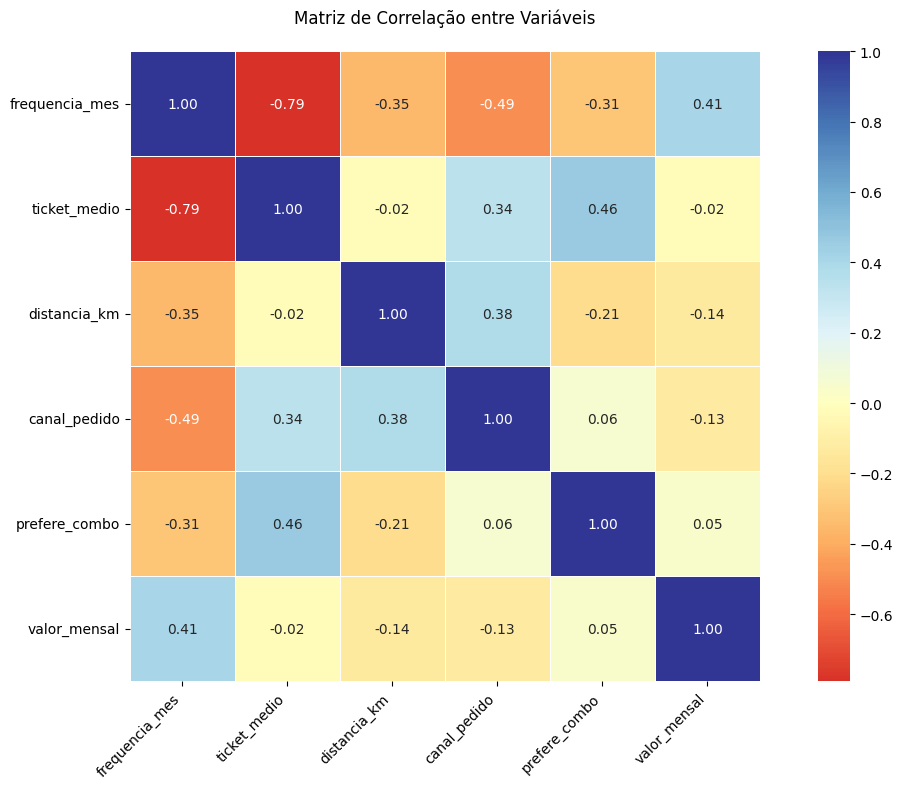

In [3]:
# Importar seaborn para criar o heatmap
import seaborn as sns

# Calcular a matriz de correlação
correlation_matrix = df[features].corr()

# Criar uma figura maior para melhor visualização
plt.figure(figsize=(12, 8))

# Criar heatmap com seaborn
sns.heatmap(correlation_matrix, 
            annot=True,      # Mostrar os valores numéricos
            cmap='RdYlBu',   # Esquema de cores (vermelho para negativo, azul para positivo)
            center=0,        # Centralizar o colormap em 0
            fmt='.2f',       # Formato dos números (2 casas decimais)
            square=True,     # Células quadradas
            linewidths=0.5)  # Linhas entre as células

# Configurar o título e rótulos
plt.title('Matriz de Correlação entre Variáveis', pad=20)

# Rotacionar os labels para melhor legibilidade
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()


In [4]:
# 2) Selecionar apenas colunas numéricas relevantes (excluir rótulos/categorias textuais)

X = df[features].copy()

# 3) Tratar valores ausentes, se houver (opcional)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

# 4) Padronizar (K-Means é sensível a escala)
scaler = StandardScaler()
X_ready = scaler.fit_transform(X)

## Método do Cotovelo (Elbow Method)
Calcule a inércia (soma das distâncias quadráticas aos centróides) para diferentes valores de **k** e observe onde o gráfico forma um 'joelho'. Esse ponto sugere um bom número de clusters.

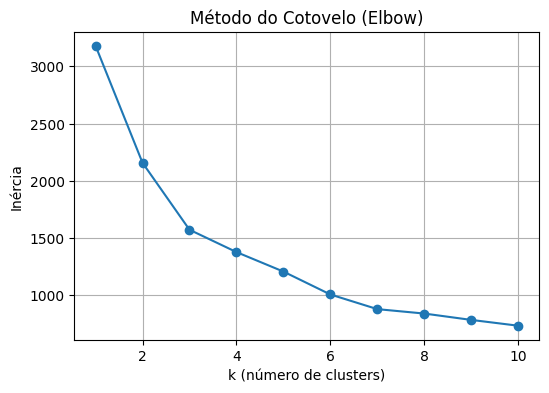

In [5]:
inertias = []
k_values = list(range(1, 11))
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto') #n_init é a definição de quantas vezes o algoritmo será executado com diferentes centroides iniciais, = auto siginfica que o sklearn escolherá um valor adequado com base no número de clusters
    km.fit(X_ready)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('k (número de clusters)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo (Elbow)')
plt.grid(True)
plt.show()

## Treino do K-Means
Escolha **k** com base no gráfico do cotovelo. Ajuste o valor de `k` abaixo conforme o joelho observado.

In [6]:
k = 3  # Ajuste este valor conforme o gráfico do cotovelo
km = KMeans(n_clusters=k, random_state=42, n_init='auto') #n_init é a definição de quantas vezes o algoritmo será executado com diferentes centroides iniciais, = auto siginfica que o sklearn escolherá um valor adequado com base no número de clusters
labels = km.fit_predict(X_ready) # Rótulos dos clusters para cada ponto de dados
df['cluster'] = labels # Adiciona os rótulos dos clusters ao DataFrame original

centers = km.cluster_centers_ # Centróides no espaço padronizado
df.head()

,segmento,frequencia_mes,ticket_medio,distancia_km,canal_pedido,prefere_combo,valor_mensal,cluster
0,Cliente_Bairro,11,28.34,0.95,0,1,311.74,0
1,Delivery_Solteiro,5,71.17,3.72,1,0,355.85,2
2,Cliente_Bairro,11,31.99,0.78,0,1,351.89,0
3,Delivery_Solteiro,3,47.37,2.93,1,0,142.11,2
4,Delivery_Solteiro,7,49.54,4.64,1,1,346.78,2


## Visualização dos Clusters

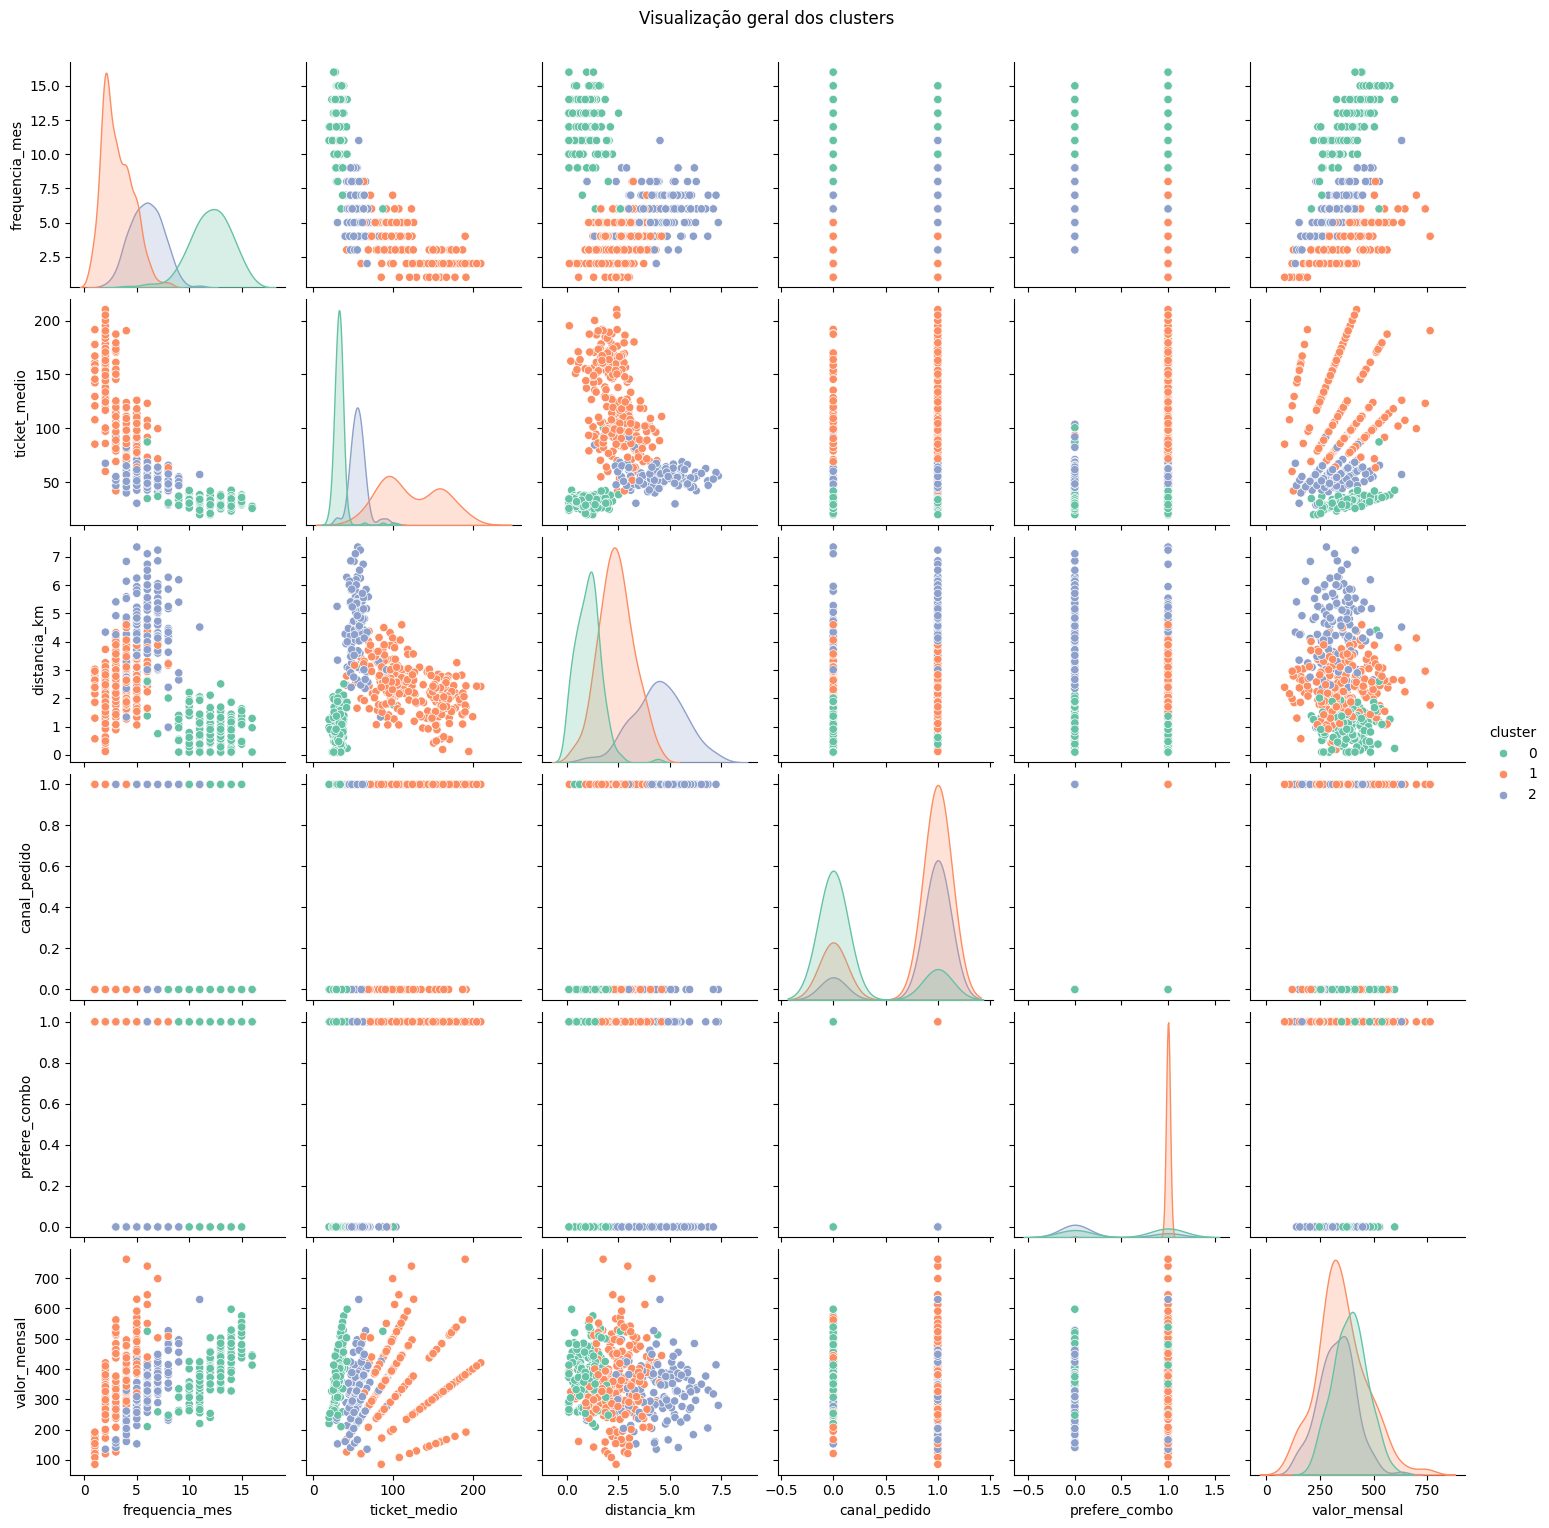

In [7]:
sns.pairplot(df, hue='cluster', diag_kind='kde', palette='Set2')
plt.suptitle("Visualização geral dos clusters", y=1.02) #y ajusta a posição do título
plt.show()

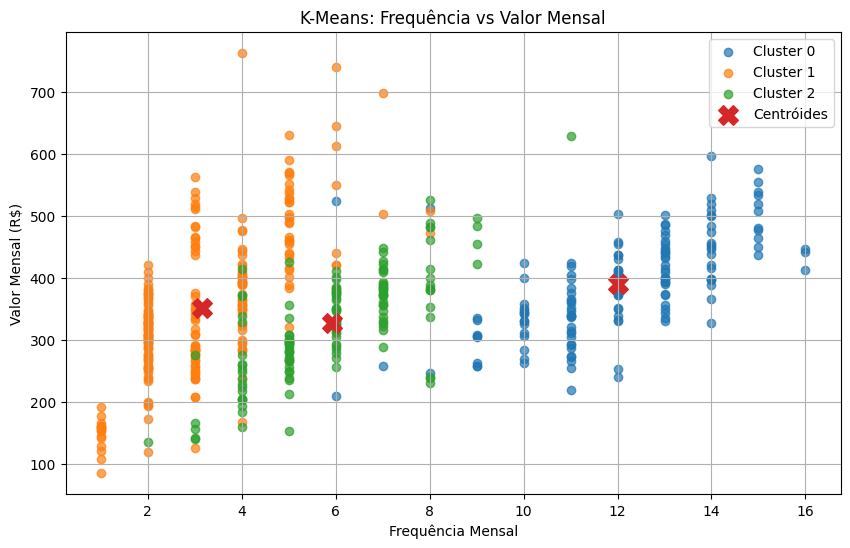

In [8]:
# 1. Visualização: Frequência Mensal vs Valor Mensal

plt.figure(figsize=(10,6))
for c in range(k):
    subset = df[df['cluster'] == c]
    plt.scatter(subset['frequencia_mes'], subset['valor_mensal'], 
               label=f'Cluster {c}', alpha=0.7) #alpha é a transparência dos pontos

centers_transformed = scaler.inverse_transform(centers)
plt.scatter(centers_transformed[:,0], centers_transformed[:,5], 
           s=200, marker='X', label='Centróides')
plt.xlabel('Frequência Mensal')
plt.ylabel('Valor Mensal (R$)')
plt.title('K-Means: Frequência vs Valor Mensal')
plt.legend()
plt.grid(True)
plt.show()

### Análise: Frequência Mensal vs Valor Mensal

Esta visualização nos revela padrões importantes no comportamento de consumo:

- **Cluster 0:** Clientes com frequência moderada e valor mensal mais baixo
  * Provavelmente são clientes do dia a dia
  * Gastam menos por mês, mesmo com visitas regulares
  * Representam o público fiel mas de menor valor total

- **Cluster 1:** Caracterizado por menor frequência mas valor mensal mais alto
  * Fazem menos visitas mas gastam mais por mês
  * Possivelmente fazem pedidos maiores para família/grupos
  * Alto valor agregado mensal mesmo com menos visitas

- **Cluster 2:** Apresenta mix de frequência e valor mensal moderados
  * Clientes regulares com gastos mensais consistentes
  * Equilíbrio entre número de visitas e valor total
  * Possivelmente o segmento mais estável em termos de receita

**Oportunidades identificadas:**
1. Aumentar valor mensal do Cluster 0 com programas de fidelidade baseados em gasto total
2. Manter e expandir base do Cluster 1 com benefícios para grandes pedidos
3. Usar Cluster 2 como referência para conversão de outros clientes

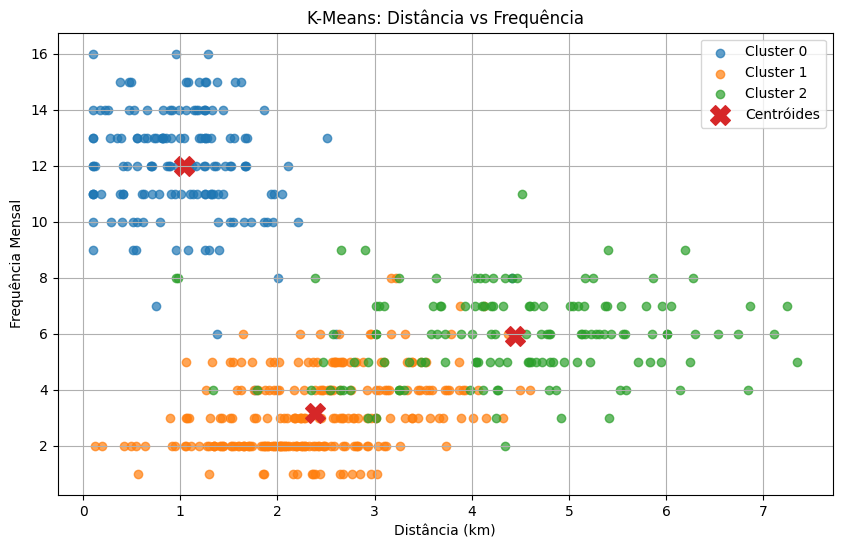

In [9]:
# 2. Visualização: Frequência vs Distância
plt.figure(figsize=(10,6))
for c in range(k):
    subset = df[df['cluster'] == c]
    plt.scatter(subset['distancia_km'], subset['frequencia_mes'], 
               label=f'Cluster {c}', alpha=0.7)

plt.scatter(centers_transformed[:,2], centers_transformed[:,0], 
           s=200, marker='X', label='Centróides')
plt.xlabel('Distância (km)')
plt.ylabel('Frequência Mensal')
plt.title('K-Means: Distância vs Frequência')
plt.legend()
plt.grid(True)
plt.show()

### Análise: Frequência vs Distância

A relação entre distância e frequência de visitas mostra padrões claros:

- **Correlação Negativa:**
  * Quanto maior a distância, menor tende a ser a frequência
  * Clientes próximos são mais propensos a visitas frequentes
  * Existem exceções interessantes que merecem atenção

- **Por Cluster:**
  * **Cluster 0:** Concentrado em distâncias menores com alta frequência
    - São os clientes da vizinhança
    - Público mais fiel e regular
  * **Cluster 1:** Distribuído em distâncias maiores
    - Frequência mais baixa
    - Possível público-alvo para delivery
  * **Cluster 2:** Distribuição intermediária
    - Mix de comportamentos
    - Potencial para aumentar frequência

**Implicações para o Negócio:**
1. Foco em conveniência para clientes distantes
2. Programa de fidelidade baseado em distância
3. Estratégias diferentes para cada raio de distância

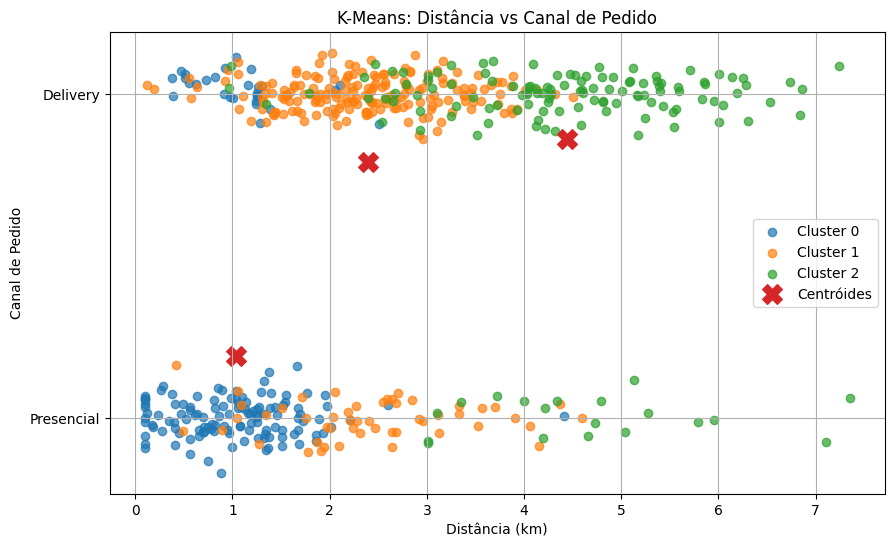

In [10]:
# 3. Visualização: Distância vs Canal de Pedido
plt.figure(figsize=(10,6))
for c in range(k):
    subset = df[df['cluster'] == c]
    # Adiciona um pequeno ruído aleatório ao canal_pedido para melhor visualização
    jitter = np.random.normal(0, 0.05, size=len(subset))
    plt.scatter(subset['distancia_km'], subset['canal_pedido'] + jitter, 
               label=f'Cluster {c}', alpha=0.7)

plt.scatter(centers_transformed[:,2], centers_transformed[:,3], 
           s=200, marker='X', label='Centróides')
plt.xlabel('Distância (km)')
plt.ylabel('Canal de Pedido')
plt.title('K-Means: Distância vs Canal de Pedido')
plt.yticks([0, 1], ['Presencial', 'Delivery'])
plt.legend()
plt.grid(True)
plt.show()

### Análise: Distância vs Canal de Pedido

Esta visualização revela padrões cruciais no comportamento de pedidos:

- **Padrão Geral:**
  * Forte correlação entre distância e escolha do canal
  * Ponto de virada em torno de 2-3 km
  * Clusters bem definidos por canal de pedido

- **Análise por Canal:**
  * **Pedidos Presenciais (0):**
    - Dominante em distâncias curtas (até 2 km)
    - Alta concentração de clientes locais
    - Maior variabilidade em clusters específicos
  
  * **Pedidos Delivery (1):**
    - Predominante em distâncias maiores
    - Alguns casos mesmo em curtas distâncias
    - Distribuição mais uniforme entre clusters

- **Comportamento dos Clusters:**
  * **Cluster 0:** Predominantemente presencial, próximo
  * **Cluster 1:** Forte tendência para delivery, mais distante
  * **Cluster 2:** Mix de canais, distâncias intermediárias

**Recomendações:**
1. Otimizar raio de entrega baseado nos padrões observados
2. Estratégias diferenciadas por distância
3. Promoções específicas para cada canal de pedido

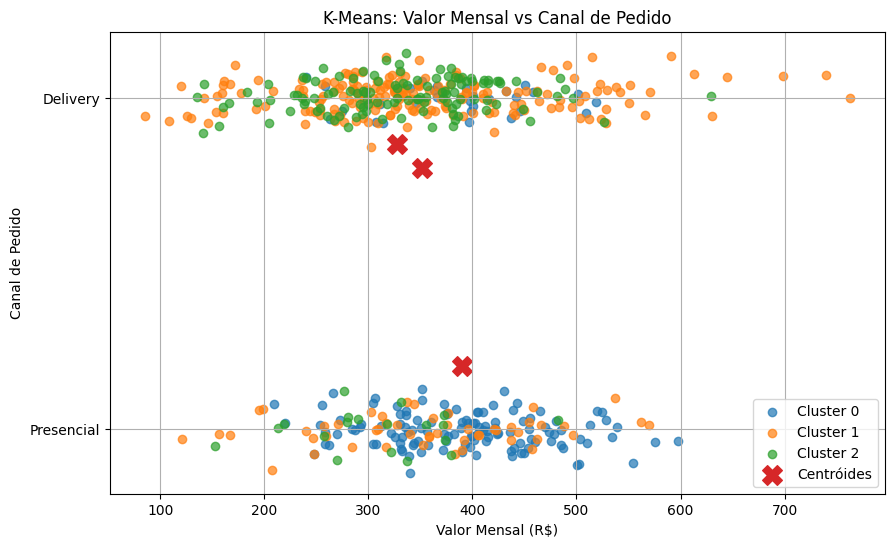

In [11]:
# 4. Visualização: Valor Mensal vs Canal de Pedido
plt.figure(figsize=(10,6))
for c in range(k):
    subset = df[df['cluster'] == c]
    jitter = np.random.normal(0, 0.05, size=len(subset))
    plt.scatter(subset['valor_mensal'], subset['canal_pedido'] + jitter, 
               label=f'Cluster {c}', alpha=0.7)

plt.scatter(centers_transformed[:,5], centers_transformed[:,3], 
           s=200, marker='X', label='Centróides')
plt.xlabel('Valor Mensal (R$)')
plt.ylabel('Canal de Pedido')
plt.title('K-Means: Valor Mensal vs Canal de Pedido')
plt.yticks([0, 1], ['Presencial', 'Delivery'])
plt.legend()
plt.grid(True)
plt.show()

### Análise: Valor Mensal vs Canal de Pedido

Observamos relações interessantes entre o valor mensal e o canal escolhido:

- **Padrões de Valor por Canal:**
  * **Pedidos Presenciais:**
    - Maior variabilidade no valor mensal
    - Tendência a valores mensais menores
    - Concentração de clientes com gastos mensais moderados
  
  * **Pedidos Delivery:**
    - Valor mensal geralmente mais alto
    - Maior consistência nos gastos mensais
    - Indica maior fidelização em termos de valor

- ### Comportamento dos Clusters:
  * **Cluster 0:** 
    - Predominância de valores mensais menores
    - Mais pedidos presenciais
    - Oportunidade para aumentar gasto mensal
  
  * **Cluster 1:**
    - Valores mensais mais altos
    - Forte presença de delivery
    - Clientes de maior valor para o negócio

  * **Cluster 2:**
    - Valores mensais intermediários
    - Mix de canais
    - Potencial para aumento do valor mensal

**Insights para Ação:**
1. Estratégias de assinatura mensal para delivery
2. Promoções progressivas baseadas no gasto mensal
3. Programa de pontos com benefícios crescentes conforme valor mensal

# 📊 Análise dos Perfis de Clientes

Com base na análise dos clusters, podemos identificar diferentes perfis de clientes com características distintas. Vamos analisar cada grupo detalhadamente, considerando seus padrões de consumo, comportamento e valor para o negócio.

### 🎯 Principais Métricas Analisadas
- **Frequência Mensal**: Número médio de visitas por mês
- **Valor Mensal**: Gasto total mensal por cliente
- **Distância**: Distância média entre o cliente e o estabelecimento
- **Uso de Delivery**: Porcentagem de pedidos feitos por delivery
- **Preferência por Combos**: Porcentagem de pedidos incluindo combos

A tabela acima mostra as características médias de cada cluster, permitindo uma visão clara dos diferentes perfis de clientes. Cada grupo apresenta um conjunto único de características que pode ser usado para desenvolver estratégias de marketing e atendimento personalizadas.

### 📈 Insights Importantes
1. **Distribuição dos Clientes**: A distribuição entre os clusters nos mostra quais perfis são mais comuns
2. **Valor x Frequência**: Relação entre o valor mensal gasto e a frequência de visitas
3. **Comportamento de Consumo**: Padrões de uso de delivery e preferência por combos
4. **Localização**: Influência da distância no comportamento de compra

### 💡 Recomendações
- Desenvolver estratégias específicas para cada perfil de cliente
- Focar em aumentar o valor mensal dos grupos com maior potencial
- Otimizar o serviço de delivery para clusters com maior demanda
- Criar promoções de combos direcionadas aos perfis mais receptivos

In [12]:
# Análise das características médias de cada cluster
cluster_analysis = df.groupby('cluster')[features].mean()

# Renomear as colunas para melhor apresentação
cluster_analysis.columns = [
    'Frequência Mensal',
    'Ticket Médio (R$)',
    'Distância (km)',
    'Uso Delivery (%)',
    'Preferência Combo (%)',
    'Valor Mensal (R$)'
]

# Formatar as colunas
cluster_analysis['Ticket Médio (R$)'] = cluster_analysis['Ticket Médio (R$)'].round(2)
cluster_analysis['Valor Mensal (R$)'] = cluster_analysis['Valor Mensal (R$)'].round(2)
cluster_analysis['Distância (km)'] = cluster_analysis['Distância (km)'].round(2)
cluster_analysis['Uso Delivery (%)'] = (cluster_analysis['Uso Delivery (%)'] * 100).round(1)
cluster_analysis['Preferência Combo (%)'] = (cluster_analysis['Preferência Combo (%)'] * 100).round(1)

# Criar tabela estilizada para características médias
print("\n=== Características Médias por Cluster ===")
display(cluster_analysis.style
        .format({
            'Frequência Mensal': '{:.1f}',
            'Ticket Médio (R$)': 'R$ {:.2f}',
            'Valor Mensal (R$)': 'R$ {:.2f}',
            'Distância (km)': '{:.1f}',
            'Uso Delivery (%)': '{:.1f}%',
            'Preferência Combo (%)': '{:.1f}%'
        })
        .set_caption("Perfil Médio dos Clusters"))

# Contagem de clientes por cluster
cluster_sizes = df['cluster'].value_counts().sort_index()
cluster_percentages = (cluster_sizes / len(df) * 100).round(1)
size_df = pd.DataFrame({
    'Quantidade de Clientes': cluster_sizes,
    'Porcentagem do Total (%)': cluster_percentages
})

print("\n=== Distribuição de Clientes por Cluster ===")
display(size_df.style
        .format({
            'Quantidade de Clientes': '{:,.0f}',
            'Porcentagem do Total (%)': '{:.1f}%'
        })
        .background_gradient(cmap='Blues')
        .set_caption("Tamanho dos Clusters"))

# Criar um resumo mais detalhado dos comportamentos
summary_df = pd.DataFrame({
    'Cluster': range(k),
    'Tamanho': cluster_sizes,
    'Freq. Mensal Média': cluster_analysis['Frequência Mensal'],
    'Valor Mensal': cluster_analysis['Valor Mensal (R$)'],
    'Distância Média': cluster_analysis['Distância (km)'],
    '% Delivery': cluster_analysis['Uso Delivery (%)'],
    '% Combos': cluster_analysis['Preferência Combo (%)']
})

# Identificar características principais de cada cluster
for i in range(k):
    print(f"\n=== Perfil do Cluster {i} ===")
    perfil = []
    row = summary_df.iloc[i]
    
    # Tamanho do cluster
    perfil.append(f"• Contém {row['Tamanho']} clientes ({(row['Tamanho']/len(df)*100):.1f}% do total)")
    
    # Frequência
    if row['Freq. Mensal Média'] > summary_df['Freq. Mensal Média'].mean():
        perfil.append("• Frequência de visitas ACIMA da média")
    else:
        perfil.append("• Frequência de visitas ABAIXO da média")
    
    # Valor Mensal
    if row['Valor Mensal'] > summary_df['Valor Mensal'].mean():
        perfil.append(f"• Alto valor mensal (R$ {row['Valor Mensal']:.2f})")
    else:
        perfil.append(f"• Baixo valor mensal (R$ {row['Valor Mensal']:.2f})")
    
    # Delivery
    if row['% Delivery'] > 50:
        perfil.append(f"• Preferem delivery ({row['% Delivery']:.1f}% dos pedidos)")
    else:
        perfil.append(f"• Preferem presencial ({100-row['% Delivery']:.1f}% dos pedidos)")
    
    # Combos
    if row['% Combos'] > 50:
        perfil.append(f"• Alta adesão a combos ({row['% Combos']:.1f}%)")
    else:
        perfil.append(f"• Baixa adesão a combos ({row['% Combos']:.1f}%)")
    
    # Distância
    if row['Distância Média'] > summary_df['Distância Média'].mean():
        perfil.append(f"• Residem mais distante ({row['Distância Média']:.1f}km em média)")
    else:
        perfil.append(f"• Residem mais próximo ({row['Distância Média']:.1f}km em média)")
    
    # Imprimir perfil
    for item in perfil:
        print(item)


=== Características Médias por Cluster ===


,Frequência Mensal,Ticket Médio (R$),Distância (km),Uso Delivery (%),Preferência Combo (%),Valor Mensal (R$)
cluster,,,,,,
0,12.0,R$ 33.04,1.0,19.2%,55.0%,R$ 389.65
1,3.2,R$ 122.65,2.4,78.9%,99.6%,R$ 351.36
2,5.9,R$ 56.28,4.5,86.1%,24.1%,R$ 327.65



=== Distribuição de Clientes por Cluster ===


,Quantidade de Clientes,Porcentagem do Total (%)
cluster,,
0,151,28.5%
1,242,45.7%
2,137,25.8%



=== Perfil do Cluster 0 ===
• Contém 151.0 clientes (28.5% do total)
• Frequência de visitas ACIMA da média
• Alto valor mensal (R$ 389.65)
• Preferem presencial (80.8% dos pedidos)
• Alta adesão a combos (55.0%)
• Residem mais próximo (1.0km em média)

=== Perfil do Cluster 1 ===
• Contém 242.0 clientes (45.7% do total)
• Frequência de visitas ABAIXO da média
• Baixo valor mensal (R$ 351.36)
• Preferem delivery (78.9% dos pedidos)
• Alta adesão a combos (99.6%)
• Residem mais próximo (2.4km em média)

=== Perfil do Cluster 2 ===
• Contém 137.0 clientes (25.8% do total)
• Frequência de visitas ABAIXO da média
• Baixo valor mensal (R$ 327.65)
• Preferem delivery (86.1% dos pedidos)
• Baixa adesão a combos (24.1%)
• Residem mais distante (4.5km em média)


In [13]:
# Importar as métricas de qualidade do scikit-learn
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calcular as diferentes métricas para o modelo atual
# Inércia: soma das distâncias quadráticas aos centróides (quanto menor, melhor)
inercia = km.inertia_

# Silhouette: mede a similaridade de um ponto com seu cluster vs outros clusters (varia de -1 a 1, quanto maior melhor)
silhouette = silhouette_score(X_ready, labels)

# Davies-Bouldin: mede a similaridade média entre clusters (quanto menor, melhor)
davies = davies_bouldin_score(X_ready, labels)

# Calinski-Harabasz: mede a razão entre a dispersão entre clusters e dentro dos clusters (quanto maior, melhor)
calinski = calinski_harabasz_score(X_ready, labels)

# Imprimir os resultados formatados
print("\nMétricas de Qualidade do Agrupamento:")
print(f"Inércia: {inercia:.2f}")           # Formato com 2 casas decimais
print(f"Silhouette Score: {silhouette:.3f}")  # Formato com 3 casas decimais
print(f"Davies-Bouldin: {davies:.3f}")        # Formato com 3 casas decimais
print(f"Calinski-Harabasz: {calinski:.1f}")   # Formato com 1 casa decimal


Métricas de Qualidade do Agrupamento:
Inércia: 1571.62
Silhouette Score: 0.347
Davies-Bouldin: 1.172
Calinski-Harabasz: 269.7


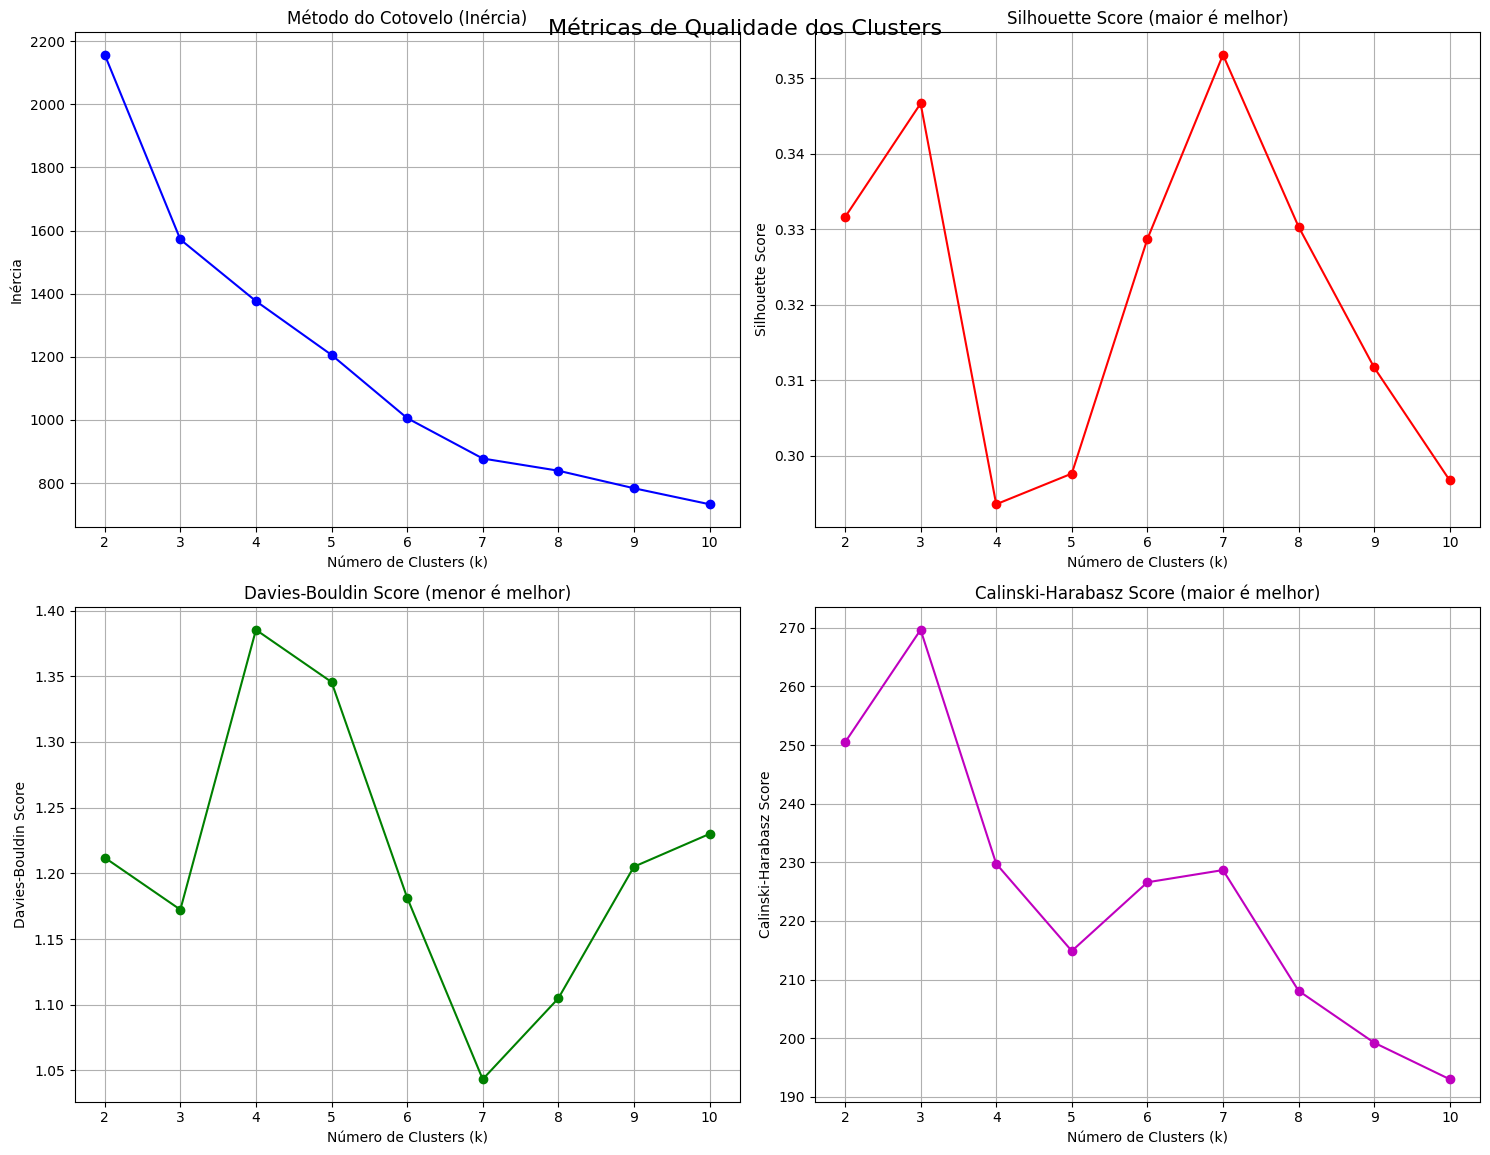


Métricas de qualidade para diferentes valores de k:


,k,Inércia,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,2,2156.9,0.332,1.212,250.5
1,3,1571.6,0.347,1.172,269.7
2,4,1376.4,0.294,1.385,229.8
3,5,1205.8,0.298,1.346,214.9
4,6,1005.6,0.329,1.182,226.6
5,7,877.6,0.353,1.043,228.7
6,8,839.0,0.330,1.105,208.1
7,9,783.4,0.312,1.205,199.2
8,10,732.7,0.297,1.230,193.0


In [14]:
# Calcular todas as métricas para diferentes valores de k
# Definir o range de valores de k a serem testados
k_values = range(2, 11)  # Começa em 2 pois algumas métricas não funcionam com k=1

# Inicializar listas vazias para armazenar os resultados
silhouette_scores = []    # Lista para scores de Silhouette
davies_bouldin_scores = [] # Lista para scores de Davies-Bouldin
calinski_harabasz_scores = [] # Lista para scores de Calinski-Harabasz
inertias = []            # Lista para valores de inércia

# Testar diferentes valores de k
for k in k_values:
    # Criar e treinar um novo modelo K-means para cada k
    km_temp = KMeans(n_clusters=k, random_state=42, n_init='auto')
    # Obter as predições dos clusters
    labels_temp = km_temp.fit_predict(X_ready)
    
    # Calcular e armazenar cada métrica
    silhouette_scores.append(silhouette_score(X_ready, labels_temp))
    davies_bouldin_scores.append(davies_bouldin_score(X_ready, labels_temp))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_ready, labels_temp))
    inertias.append(km_temp.inertia_)

# Configurar o layout dos subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # Criar grade 2x2 de subplots
fig.suptitle('Métricas de Qualidade dos Clusters', fontsize=16, y=0.95)  # Título principal

# 1. Plotar Inércia (Método do Cotovelo)
axes[0, 0].plot(k_values, inertias, 'bo-')  # Linha azul com pontos
axes[0, 0].set_xlabel('Número de Clusters (k)')
axes[0, 0].set_ylabel('Inércia')
axes[0, 0].set_title('Método do Cotovelo (Inércia)')
axes[0, 0].grid(True)

# 2. Plotar Silhouette Score
axes[0, 1].plot(k_values, silhouette_scores, 'ro-')  # Linha vermelha com pontos
axes[0, 1].set_xlabel('Número de Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (maior é melhor)')
axes[0, 1].grid(True)

# 3. Plotar Davies-Bouldin Score
axes[1, 0].plot(k_values, davies_bouldin_scores, 'go-')  # Linha verde com pontos
axes[1, 0].set_xlabel('Número de Clusters (k)')
axes[1, 0].set_ylabel('Davies-Bouldin Score')
axes[1, 0].set_title('Davies-Bouldin Score (menor é melhor)')
axes[1, 0].grid(True)

# 4. Plotar Calinski-Harabasz Score
axes[1, 1].plot(k_values, calinski_harabasz_scores, 'mo-')  # Linha magenta com pontos
axes[1, 1].set_xlabel('Número de Clusters (k)')
axes[1, 1].set_ylabel('Calinski-Harabasz Score')
axes[1, 1].set_title('Calinski-Harabasz Score (maior é melhor)')
axes[1, 1].grid(True)

# Ajustar o layout e mostrar os gráficos
plt.tight_layout()
plt.show()

# Criar tabela com todas as métricas
metrics_df = pd.DataFrame({
    'k': k_values,
    'Inércia': inertias,
    'Silhouette': silhouette_scores,
    'Davies-Bouldin': davies_bouldin_scores,
    'Calinski-Harabasz': calinski_harabasz_scores
})

print("\nMétricas de qualidade para diferentes valores de k:")
# Mostrar tabela estilizada com formatação e gradientes de cor
display(metrics_df.style
        .format({  # Definir formato dos números
            'Inércia': '{:.1f}',            # Uma casa decimal
            'Silhouette': '{:.3f}',         # Três casas decimais
            'Davies-Bouldin': '{:.3f}',     # Três casas decimais
            'Calinski-Harabasz': '{:.1f}'   # Uma casa decimal
        })
        # Gradiente verde para métricas onde maior é melhor
        .background_gradient(subset=['Silhouette', 'Calinski-Harabasz'], cmap='YlGn')
        # Gradiente vermelho invertido para métricas onde menor é melhor
        .background_gradient(subset=['Davies-Bouldin', 'Inércia'], cmap='YlOrRd_r'))